# SENTIMENT ANALYSIS ON BOOK REVIEWS 

Importing required libraries

In [ ]:
# Data Exploration, cleaning and Visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP tasks (text cleaning) and Vectorization
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# ML Models training and evaulation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb

# Libraries required for CNN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

## Data Exploration

In [2]:
df = pd.read_csv("books_data.csv")
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [3]:
df.shape

(12000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12000 non-null  int64 
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
 3   summary     12000 non-null  object
dtypes: int64(2), object(2)
memory usage: 375.1+ KB


## Data Cleaning and Filtering

In [5]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0'])
# Check for missing values
df.isnull().sum()

rating        0
reviewText    0
summary       0
dtype: int64

In [ ]:
duplicate_reviews = df[df.duplicated(subset='reviewText', keep=False)]

In [7]:
df.columns

Index(['rating', 'reviewText', 'summary'], dtype='object')

In [ ]:
print(df['rating'].value_counts())

5    3000
4    3000
1    2000
3    2000
2    2000
Name: rating, dtype: int64


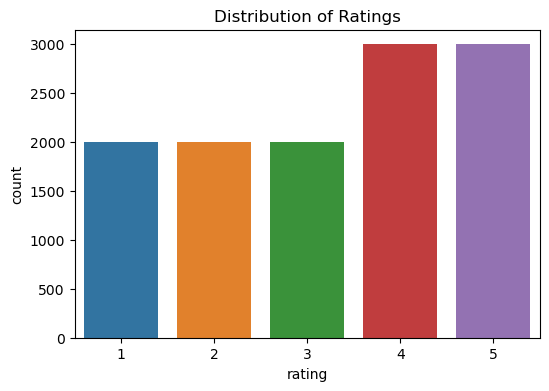

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.show()

In [10]:
# Filter out entries with a rating of 3
df = df[df['rating'] != 3]

# Update the sentiment column
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

In [ ]:
print(df['sentiment'].value_counts())

positive    6000
negative    4000
Name: sentiment, dtype: int64


In [12]:
# Check the new column
print(df[['rating', 'sentiment']].head())

   rating sentiment
0       5  positive
1       1  negative
2       5  positive
3       5  positive
4       5  positive


In [13]:
# Check the distribution of the binary sentiments
print(df['sentiment'].value_counts())

positive    6000
negative    4000
Name: sentiment, dtype: int64


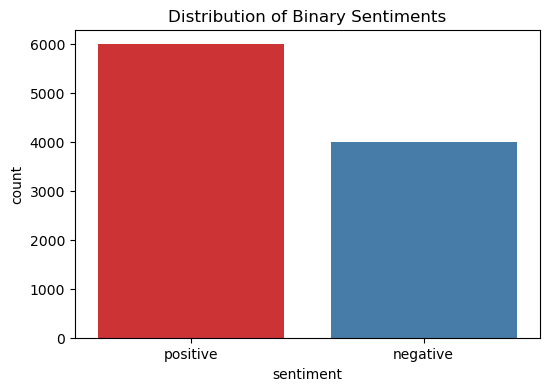

In [14]:
# Visualize the distribution of the binary sentiments
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='Set1')
plt.title('Distribution of Binary Sentiments')
plt.show()

### Word Clouds for positive and negative sentiments

In [ ]:
# Separate reviews based on sentiment
positive_reviews = df[df['sentiment'] == 'positive']['summary']
negative_reviews = df[df['sentiment'] == 'negative']['summary']

# Combine all reviews into a single string for each sentiment
positive_text = " ".join(review for review in positive_reviews)
negative_text = " ".join(review for review in negative_reviews)

pos_wc = WordCloud(width=800, height=400, background_color='black').generate(positive_text)
neg_wc = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

Text(0.5, 1.0, 'Positive Sentiment Word Cloud')

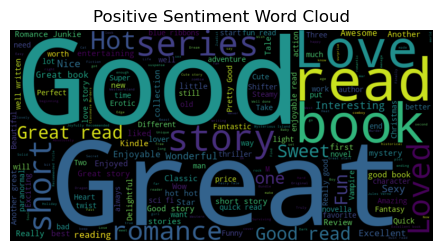

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

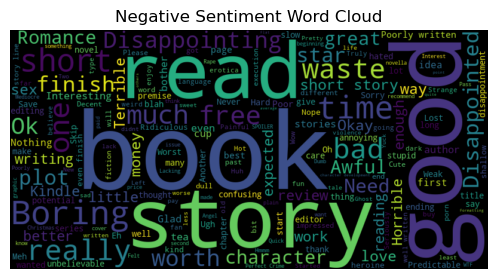

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')

plt.tight_layout()
plt.show()

## Text Preprocessing 
  Normalization 
 Tokenization                   
 Lemmatization                  
 Stopwords removal                                       
 Vectorization 

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Function to clean the review text
def clean_review(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters, numbers, and punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['reviewText'].apply(clean_review)

In [20]:
# Check the cleaned reviews
df[['reviewText', 'cleaned_review']].head()

,reviewText,cleaned_review
0,This book was the very first bookmobile book I...,book first bookmobile book bought school book ...
1,"When I read the description for this book, I c...",read description book couldnt wait read downlo...
2,I just had to edit this review. This book is a...,edit review book believe got right updated rew...
3,I don't normally buy 'mystery' novels because ...,dont normally buy mystery novel dont like howe...
4,"This isn't the kind of book I normally read, a...",isnt kind book normally read although try limi...


In [ ]:
tfidf = TfidfVectorizer( ngram_range=(1,3), max_features=5000) 

X = tfidf.fit_transform(df['cleaned_review']).toarray()

print(f"Shape of the feature matrix: {X.shape}")
print(f"Shape of the feature matrix with n-grams: {X.shape}")

Shape of the feature matrix: (10000, 5000)
Shape of the feature matrix with n-grams: (10000, 5000)


In [ ]:
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Map sentiments to binary values

Splitting data into training and testing for model training (80/20 split used)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
# Check shapes of the resulting datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (8000, 5000)
Shape of X_test: (2000, 5000)
Shape of y_train: (8000,)
Shape of y_test: (2000,)


# Model Training 
1. Logistic Regression
2. SVM
3. XGBoost (removed)
4. Random forest (removed)

In [ ]:
model = LogisticRegression(C=10,solver='liblinear', penalty='l2',max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=200, solver='liblinear')

In [ ]:
y_pred = model.predict(X_test)

## Logistic Regression Result

In [ ]:
print("Logistic Regression  ")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression  
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       800
           1       0.89      0.92      0.91      1200

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000

Confusion Matrix:
[[ 667  133]
 [  98 1102]]


In [ ]:
svm_model = svm.SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
y_pred_svm = svm_model.predict(X_test)


## SVM Result

In [ ]:
accuracy = accuracy_score(y_test, y_pred_svm)
classification_rep = classification_report(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       800
           1       0.88      0.92      0.90      1200

    accuracy                           0.88      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.88      0.88      2000

Confusion Matrix:
[[ 656  144]
 [  96 1104]]


# Deep Learning (CNN)

In [ ]:
# Use cleaned text reviews directly for CNN
X = df['cleaned_review'].values

# Tokenization and Padding for CNN
max_words = 10000  # Maximum number of words to consider
max_sequence_length = 100  # Maximum length of each sequence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

# Convert texts to sequences
X_seq = tokenizer.texts_to_sequences(X)

# Pad the sequences to ensure consistent input length
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)


In [ ]:
# Encode the target sentiment values (1 for positive, 0 for negative)
y = df['sentiment'].map({'positive': 1, 'negative': 0}).values

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
embedding_dim = 100  # Size of the embedding vectors

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a 1D Convolutional layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

# Add a second convolutional layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.5))  # Another dropout layer

# Add a global max pooling layer
model.add(GlobalMaxPooling1D())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

c:\Users\Abdul Basit\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5315 - loss: 1.2515 - val_accuracy: 0.4000 - val_loss: 0.7155
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5909 - loss: 0.6845 - val_accuracy: 0.6163 - val_loss: 0.6734
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6264 - loss: 0.6413 - val_accuracy: 0.8090 - val_loss: 0.4262
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8554 - loss: 0.3488 - val_accuracy: 0.8577 - val_loss: 0.3321
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9248 - loss: 0.2089 - val_accuracy: 0.8533 - val_loss: 0.3707
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9563 - loss: 0.1298 - val_accuracy: 0.8557 - val_loss: 0.3587
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9683 - loss: 0.1013 - val_accuracy: 0.8440 - val_loss: 0.4326
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8532 - loss: 0.3417
Test Accuracy: 0.8577


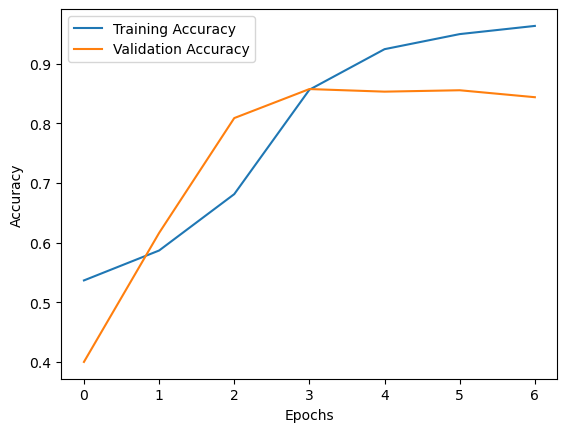

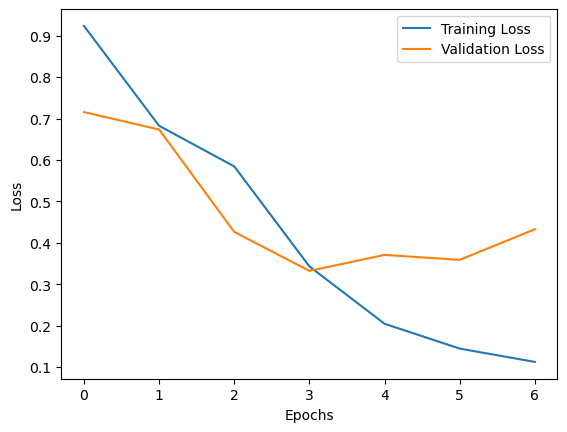

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## CNN Result

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n {conf_matrix}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8532 - loss: 0.3417
Test Accuracy: 0.8577
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

    Negative       0.86      0.77      0.81      1200
    Positive       0.86      0.92      0.89      1800

    accuracy                           0.86      3000
   macro avg       0.86      0.84      0.85      3000
weighted avg       0.86      0.86      0.86      3000

Confusion Matrix:
 [[ 920  280]
 [ 147 1653]]
